This validation is not described in detail in the thesis. It is also not as meaningful by far as the *leave-one-protein-out cross-validation*. Nevertheless, it allows for a comparison with the McGuinness et al. paper.

Intention of this notebook is to evaluate (in a retrospective manner) the most relevant models trained on the T1626 dataset (also filtered).

Additionally, the model performance of the S_E model is visualized on a per protein basis, which shows significant variance, irrespectiev of the example of muatants.

For current nomenclature refer to the model names in brackets.

## Notebook Setup

In [0]:
#Imports:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error,roc_curve, auc
import matplotlib.pyplot as plt
import pickle as pkl
import pylab
import seaborn as sns

In [0]:
#Connect to google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
#Set up file paths:
data_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T251/cnn_rep_sampler_T251/"
base_data_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/T251/paper_datasets_T251/"
model_folder_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Models/Validation_Models/"
fig_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Validation/Retrospective_T251/"

y_target_loc = base_data_folder_loc + "y_label_xgboost_T251.csv"
X_paper_loc =  base_data_folder_loc + "X_paper_xgboost_T251.csv"

X_seq_all_01_loc =  data_folder_loc + "sequence_cnn_rep_all_default_01.csv"
X_seq_all_02_loc =  data_folder_loc + "sequence_cnn_rep_all_default_02.csv"
X_seq_all_03_loc =  data_folder_loc + "sequence_cnn_rep_all_default_03.csv"

model_seq_rep_loc = model_folder_loc + "model_cnn_all_01_02_03_xgboost_T1626.pkl"
model_seq_rep_filtered_loc = model_folder_loc + "model_cnn_all_01_02_03_xgboost_T1626_filtered.pkl"
model_paper_loc = model_folder_loc + "model_paper_xgboost_T1626.pkl"
model_paper_filtered_loc = model_folder_loc + "model_paper_xgboost_T1626_filtered.pkl"
model_combined_loc = model_folder_loc + "model_paper_cnn_01_02_03_all_xgboost_T1626.pkl"
model_combined_filtered_loc = model_folder_loc + "model_paper_cnn_01_02_03_all_xgboost_T1626_filtered.pkl"

merck_and_co_excel_loc = "gdrive/My Drive/iGEM/Databases/Merck&Co/Data/Source/merck_and_co.xls"

print("Folders: ")
print("\t",os.path.isdir(data_folder_loc))
print("\t",os.path.isdir(base_data_folder_loc))
print("\t",os.path.isdir(model_folder_loc))
print("\t",os.path.isdir(fig_loc))
print("Files: ")
print("\t",os.path.isfile(y_target_loc))
print("\t",os.path.isfile(X_seq_all_01_loc))
print("\t",os.path.isfile(X_seq_all_02_loc))
print("\t",os.path.isfile(X_seq_all_03_loc))
print("\t",os.path.isfile(X_paper_loc))
print("\t",os.path.isfile(model_seq_rep_loc))
print("\t",os.path.isfile(model_seq_rep_filtered_loc))
print("\t",os.path.isfile(model_paper_loc))
print("\t",os.path.isfile(model_paper_filtered_loc))
print("\t",os.path.isfile(model_combined_loc))
print("\t",os.path.isfile(model_combined_filtered_loc))
print("\t",os.path.isfile(merck_and_co_excel_loc))

Folders: 
	 True
	 True
	 True
	 True
Files: 
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True
	 True


In [0]:
#XGBoost
!pip install xgboost==0.82 #working GPU support
import xgboost as xgb

In [0]:
#BayersianOptimization
!pip install bayesian-optimization
from bayes_opt import BayesianOptimization

## Prepare Data

In [0]:
#Just load data
y_label = pd.read_csv(y_target_loc)["dtm"].values 

X_seq_all_01 = pd.read_csv(X_seq_all_01_loc, index_col=0)
X_seq_all_01.columns = list(map(lambda x: "layer_01_"+x, X_seq_all_01.columns))
X_seq_all_02 = pd.read_csv(X_seq_all_02_loc, index_col=0)
X_seq_all_02.columns = list(map(lambda x: "layer_02_"+x, X_seq_all_02.columns))
X_seq_all_03 = pd.read_csv(X_seq_all_03_loc, index_col=0)
X_seq_all_03.columns = list(map(lambda x: "layer_03_"+x, X_seq_all_03.columns))

X_paper = pd.read_csv(X_paper_loc) 

with open(model_seq_rep_loc, 'rb') as handle:
  model_seq_rep = pkl.load(handle)
with open(model_seq_rep_filtered_loc, 'rb') as handle:
  model_seq_rep_filtered = pkl.load(handle)
with open(model_paper_loc, 'rb') as handle:
  model_paper = pkl.load(handle)
with open(model_paper_filtered_loc, 'rb') as handle:
  model_paper_filtered = pkl.load(handle)
with open(model_combined_loc, 'rb') as handle:
  model_combined = pkl.load(handle)
with open(model_combined_filtered_loc, 'rb') as handle:
  model_combined_filtered = pkl.load(handle)
  
T251_table = pd.read_excel(io=merck_and_co_excel_loc, sheet_name=1, header=0)

In [0]:
X_seq_all_01_02_03 = pd.concat([X_seq_all_01, X_seq_all_02, X_seq_all_03], axis=1)
X_seq_all_01_02_03 = X_seq_all_01_02_03.reset_index(drop=True)

In [0]:
print(X_paper.shape)
print(X_seq_all_01_02_03.shape)

(251, 158)
(251, 5376)


In [0]:
X_paper_all_01_02_03 = pd.concat([X_seq_all_01_02_03, X_paper], axis=1)

In [0]:
print(X_paper_all_01_02_03.shape)
X_paper_all_01_02_03.head()

(251, 5534)


,layer_01_wt_rep_0,layer_01_wt_rep_1,layer_01_wt_rep_2,layer_01_wt_rep_3,layer_01_wt_rep_4,layer_01_wt_rep_5,layer_01_wt_rep_6,layer_01_wt_rep_7,layer_01_wt_rep_8,layer_01_wt_rep_9,layer_01_wt_rep_10,layer_01_wt_rep_11,layer_01_wt_rep_12,layer_01_wt_rep_13,layer_01_wt_rep_14,layer_01_wt_rep_15,layer_01_wt_rep_16,layer_01_wt_rep_17,layer_01_wt_rep_18,layer_01_wt_rep_19,layer_01_wt_rep_20,layer_01_wt_rep_21,layer_01_wt_rep_22,layer_01_wt_rep_23,layer_01_wt_rep_24,layer_01_wt_rep_25,layer_01_wt_rep_26,layer_01_wt_rep_27,layer_01_wt_rep_28,layer_01_wt_rep_29,layer_01_wt_rep_30,layer_01_wt_rep_31,layer_01_wt_rep_32,layer_01_wt_rep_33,layer_01_wt_rep_34,layer_01_wt_rep_35,layer_01_wt_rep_36,layer_01_wt_rep_37,layer_01_wt_rep_38,layer_01_wt_rep_39,...,mono_fa_intra_rep,mono_fa_pair,mono_fa_rep,mono_fa_sol,mono_hbond_bb_sc,mono_hbond_lr_bb,mono_hbond_sc,mono_hbond_sr_bb,mono_omega,mono_p_aa_pp,mono_pro_close,mono_rama,mono_ref,mutability_diff,mutability_first,mutability_second,pi_diff,pi_first,pi_second,polarity2_diff,polarity2_first,polarity2_second,polarity_diff,polarity_first,polarity_second,r_bioluminate_delta_stability,r_bioluminate_delta_stability_coulomb,r_bioluminate_delta_stability_covalent,r_bioluminate_delta_stability_hbond,r_bioluminate_delta_stability_lipo,r_bioluminate_delta_stability_packing,r_bioluminate_delta_stability_reference,r_bioluminate_delta_stability_selfcont,r_bioluminate_delta_stability_solv_gb,r_bioluminate_delta_stability_solv_sa,r_bioluminate_delta_stability_vdw,totalarea,vdw_vol_diff,vdw_vol_first,vdw_vol_second
0,0.0,0.0,0.0,0.13786,0.0,0.0,0.0,0.0,0.0,0.05585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.652713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.336359,0.0,...,-0.001,-0.189,0.095,-1.741,0.138,-0.060,2.665,-0.151,-0.102,0.766,-0.058,0.100,0.83,-6,106,100,3.34,2.77,6.11,-4.9,13.0,8.1,-49.70,49.7,0.00,8.651142,59.024591,5.286400,3.542588,-0.029323,0.000000,-36.41,0.000000,-22.998830,0,0.235717,189.689,-16.3,30.0,13.7
1,0.0,0.0,0.0,0.13786,0.0,0.0,0.0,0.0,0.0,0.05585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.652713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.336359,0.0,...,-0.018,-0.338,-1.257,-6.910,0.729,0.146,2.473,0.126,0.202,0.841,-0.022,0.395,0.50,-57,106,49,3.20,2.77,5.97,-4.0,13.0,9.0,-49.70,49.7,0.00,9.998905,59.574440,1.797503,3.545229,0.897229,0.000000,-32.57,0.000000,-23.925944,0,0.680448,189.689,-26.5,30.0,3.5
2,0.0,0.0,0.0,0.13786,0.0,0.0,0.0,0.0,0.0,0.05585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.652713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.336359,0.0,...,0.008,-0.409,-0.117,-3.501,0.762,0.009,0.553,-0.255,-0.551,0.194,-0.036,-0.297,-0.22,28,106,134,2.64,2.77,5.41,-1.4,13.0,11.6,-46.32,49.7,3.38,6.235958,20.603743,3.228514,2.825580,0.030040,0.000000,5.31,-4.167533,-20.111146,0,-1.483240,189.689,2.7,30.0,32.7
3,0.0,0.0,0.0,0.13786,0.0,0.0,0.0,0.0,0.0,0.05585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.652713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.336359,0.0,...,0.009,-0.875,0.794,-1.456,0.007,0.014,0.720,0.078,-0.185,0.453,-0.029,-0.193,-0.30,-13,106,93,2.88,2.77,5.65,-2.5,13.0,10.5,-46.17,49.7,3.53,2.271928,8.343113,8.269074,3.266579,-0.811103,-0.173941,2.90,-0.086061,-17.284814,0,-2.150919,189.689,12.7,30.0,42.7
4,0.0,0.0,0.0,0.13786,0.0,0.0,0.0,0.0,0.0,0.05585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.652713,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.336359,0.0,...,0.025,-0.976,0.532,-2.320,0.118,0.008,1.645,0.074,-0.192,0.380,-0.026,-0.207,0.96,-32,106,74,3.19,2.77,5.96,-7.1,13.0,5.9,-49.57,49.7,0.13,7.370778,63.962126,6.895204,3.544219,-1.123189,0.000000,-44.23,0.000000,-21.965650,0,0.288068,189.689,4.1,30.0,34.1


In [0]:
str(list(X_paper_all_01_02_03.columns))

"['layer_01_wt_rep_0', 'layer_01_wt_rep_1', 'layer_01_wt_rep_2', 'layer_01_wt_rep_3', 'layer_01_wt_rep_4', 'layer_01_wt_rep_5', 'layer_01_wt_rep_6', 'layer_01_wt_rep_7', 'layer_01_wt_rep_8', 'layer_01_wt_rep_9', 'layer_01_wt_rep_10', 'layer_01_wt_rep_11', 'layer_01_wt_rep_12', 'layer_01_wt_rep_13', 'layer_01_wt_rep_14', 'layer_01_wt_rep_15', 'layer_01_wt_rep_16', 'layer_01_wt_rep_17', 'layer_01_wt_rep_18', 'layer_01_wt_rep_19', 'layer_01_wt_rep_20', 'layer_01_wt_rep_21', 'layer_01_wt_rep_22', 'layer_01_wt_rep_23', 'layer_01_wt_rep_24', 'layer_01_wt_rep_25', 'layer_01_wt_rep_26', 'layer_01_wt_rep_27', 'layer_01_wt_rep_28', 'layer_01_wt_rep_29', 'layer_01_wt_rep_30', 'layer_01_wt_rep_31', 'layer_01_wt_rep_32', 'layer_01_wt_rep_33', 'layer_01_wt_rep_34', 'layer_01_wt_rep_35', 'layer_01_wt_rep_36', 'layer_01_wt_rep_37', 'layer_01_wt_rep_38', 'layer_01_wt_rep_39', 'layer_01_wt_rep_40', 'layer_01_wt_rep_41', 'layer_01_wt_rep_42', 'layer_01_wt_rep_43', 'layer_01_wt_rep_44', 'layer_01_wt_rep_4

## Supplementary Functions

In [0]:
def plot_roc_curve(y_label, y_pred):
  sns.set()
  fpr, tpr, thresholds = roc_curve(y_label>0, y_pred)
  roc_auc = auc(fpr, tpr)
  plt.figure(figsize=(5, 5))
  plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=1, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver operating characteristic')
  plt.legend(loc="lower right")
  plt.show("lower right")
  plt.show()

In [0]:
def performance_per_protein_id(mutation_idx, y_label, y_pred):
  sns.set()
  mae = []
  rmse = []
  count= []
  proteins = list(set(mutation_idx))
  for prot in proteins:
    mae.append(mean_absolute_error(y_label[mutation_idx==prot], y_pred[mutation_idx==prot]))
    rmse.append(np.sqrt(mean_squared_error(y_label[mutation_idx==prot], y_pred[mutation_idx==prot])))
    count.append((mutation_idx==prot).sum())
  result = pd.concat([pd.Series(proteins), pd.Series(mae), pd.Series(rmse), pd.Series(count)], axis=1)
  result.columns=["proteins","mae","rmse","count"]
  result = result.sort_values(by="count", ascending=False)
  result = result.set_index("proteins")
  return result

In [0]:
def plot_per_protein_perf(data, y1, y2, title, save_loc):
    sns.set()
    fig, ax = plt.subplots(1, 1, figsize=(15,7))
    data[[y2,y1]].plot(kind="bar",title=title, width=.7, rot=67.5, color=["lightslategray","lightsteelblue"], stacked=False, grid=True, fontsize=14, ax=ax)
    plt.tight_layout()
    plt.savefig(save_loc, dpi=300)
    plt.show()

In [0]:
def plot_hist_label(y_label, x1, y1, title, save_loc):
    sns.set()
    pylab.rc('font', family="Sans", size=16)
    fig, ax = plt.subplots(1, 1, figsize=(7,6.5))
    y_label.plot(kind="hist",title=title, color=["lightslategray"], grid=True, fontsize=14, ax=ax, rot=45, bins=np.arange(-15,16,1.5), xticks=np.arange(-15,16,1.5))
    ax.set_ylabel(y1)
    ax.set_xlabel(x1)
    plt.tight_layout()
    for label in ax.xaxis.get_ticklabels()[1::2]:
      label.set_visible(False)
    plt.savefig(save_loc, dpi=300)
    plt.show()

In [0]:
def plot_results_bar(results_df, title, saveloc, fig_size, fig_lim):
  sns.set()
  fig, ax = plt.subplots(figsize=fig_size)
  plt.ylim(fig_lim[0], fig_lim[1])
  results_df.plot.bar(ax=ax, color=["lightslategray","lightsteelblue"], title=title, rot=45, width=.7)
  ax.xaxis.grid(False)
  plt.tight_layout()
  plt.savefig(saveloc, dpi=300)
  plt.show()

## Evaluate different models

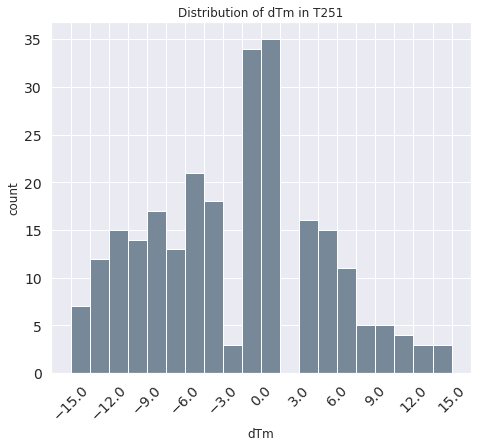

In [0]:
plot_hist_label(pd.Series(y_label),"dTm", "count", "Distribution of dTm in T251", fig_loc+"distribution_of_dTm_251.png")

### Model paper (S_E)

In [0]:
# Prepare data for XGBoost
dtest = xgb.DMatrix(X_paper)

In [0]:
y_pred = model_paper.predict(dtest)

In [0]:
print("Mean absolute error: ",mean_absolute_error(y_label, y_pred))
print("Root mean squared error: ",np.sqrt(mean_squared_error(y_label, y_pred)))



```
Mean absolute error:  4.811606817587438
Root mean squared error:  6.315121490566644
```



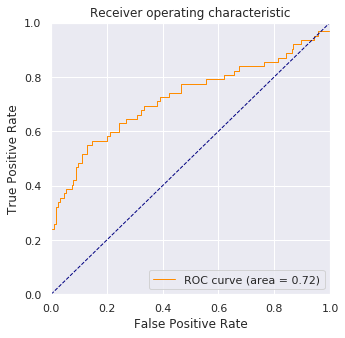

In [0]:
plot_roc_curve(y_label>1, y_pred) #PAPER USES >1 !!!

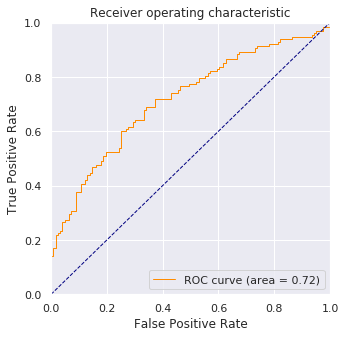

In [0]:
plot_roc_curve(y_label>-1, y_pred) #PAPER USES >1 !!!

### Model paper (filtered) (S_E_f)

In [0]:
# Prepare data for XGBoost
dtest = xgb.DMatrix(X_paper)

In [0]:
y_pred = model_paper_filtered.predict(dtest)

In [0]:
print("Mean absolute error: ",mean_absolute_error(y_label, y_pred))
print("Root mean squared error: ",np.sqrt(mean_squared_error(y_label, y_pred)))



```
Mean absolute error:  4.7998284004409
Root mean squared error:  6.23768342133395
```



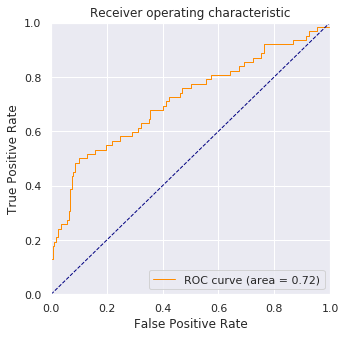

In [0]:
plot_roc_curve(y_label>1, y_pred)

### Model seq_rep (A13)

In [0]:
# Prepare data for XGBoost
dtest = xgb.DMatrix(X_seq_all_01_02_03)

In [0]:
y_pred = model_seq_rep.predict(dtest)

In [0]:
print("Mean absolute error: ",mean_absolute_error(y_label, y_pred))
print("Root mean squared error: ",np.sqrt(mean_squared_error(y_label, y_pred)))



```
Mean absolute error:  5.3255858978189785
Root mean squared error:  6.586178780998422
```



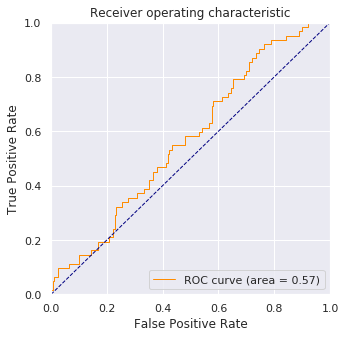

In [0]:
plot_roc_curve(y_label>1, y_pred)

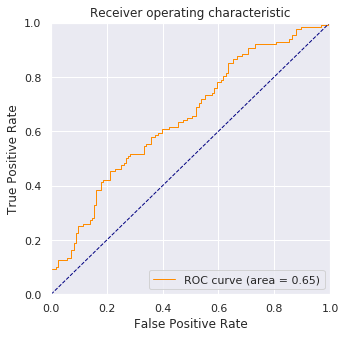

In [0]:
plot_roc_curve(y_label>-1, y_pred)

### Model seq_rep (filtered) (A13_f)

In [0]:
# Prepare data for XGBoost
dtest = xgb.DMatrix(X_seq_all_01_02_03)

In [0]:
y_pred = model_seq_rep_filtered.predict(dtest)

In [0]:
print("Mean absolute error: ",mean_absolute_error(y_label, y_pred))
print("Root mean squared error: ",np.sqrt(mean_squared_error(y_label, y_pred)))



```
Mean absolute error:  5.1279868689191295
Root mean squared error:  6.349443169207046
```



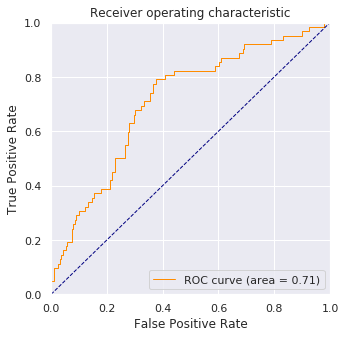

In [0]:
plot_roc_curve(y_label>1, y_pred)

### Model paper cnn 01 02 03 all (S_E_A13)

In [0]:
# Prepare data for XGBoost
dtest = xgb.DMatrix(X_paper_all_01_02_03)

In [0]:
y_pred = model_combined.predict(dtest)

In [0]:
print("Mean absolute error: ",mean_absolute_error(y_label, y_pred))
print("Root mean squared error: ",np.sqrt(mean_squared_error(y_label, y_pred)))



```
Mean absolute error:  4.911635598058244
Root mean squared error:  6.184323704780974
```



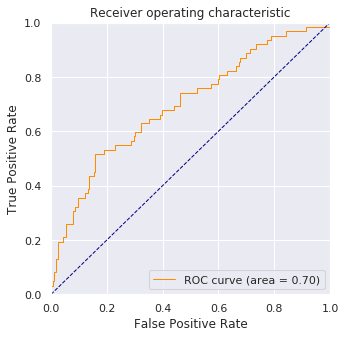

In [0]:
plot_roc_curve(y_label>1, y_pred)

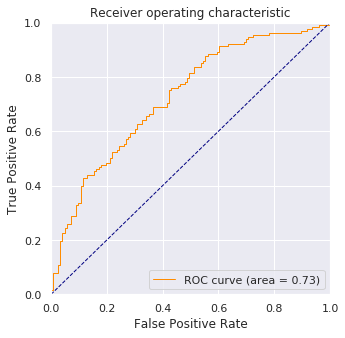

In [0]:
plot_roc_curve(y_label>-1, y_pred)

### Model paper cnn 01 02 03 all (filtered) (S_E_A13_f)

In [0]:
# Prepare data for XGBoost
dtest = xgb.DMatrix(X_paper_all_01_02_03)

In [0]:
y_pred = model_combined_filtered.predict(dtest)

In [0]:
print("Mean absolute error: ",mean_absolute_error(y_label, y_pred))
print("Root mean squared error: ",np.sqrt(mean_squared_error(y_label, y_pred)))



```
Mean absolute error:  5.044870873870128
Root mean squared error:  6.390576904652526
```



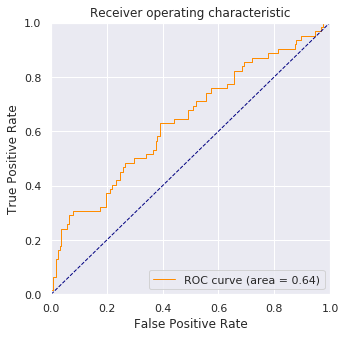

In [0]:
plot_roc_curve(y_label>1, y_pred)

## Results

### Visualize model perfomance NEW

In [0]:
columns = ["MAE","RMSE"]
index = ["S_E", "S_E_f", "A13", "A13_f", "S_E_A13", "S_E_A13_f"]
values = np.array([[4.811606817587438,6.315121490566644],
 [4.7998284004409,6.23768342133395],
 [5.3255858978189785,6.586178780998422],
 [5.1279868689191295,6.349443169207046],
 [4.911635598058244,6.184323704780974],
 [5.044870873870128,6.390576904652526]])

In [0]:
results_table = pd.DataFrame(values)
results_table.columns = columns
results_table.index = index

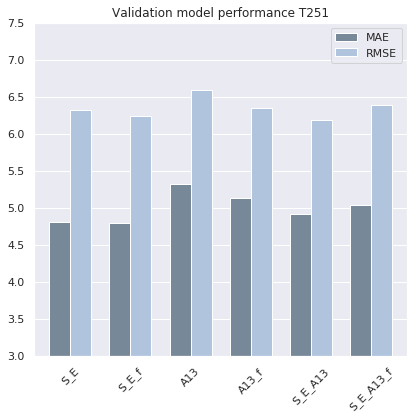

In [0]:
plot_results_bar(results_df=results_table, title="Validation model performance T251", saveloc=fig_loc+"validation_model_performance_T251_NEW.png", fig_size=(6,6), fig_lim=(3,7.5))

In [0]:
results_table = results_table.round(3)
results_table

,MAE,RMSE
S_E,4.812,6.315
S_E_f,4.800,6.238
A13,5.326,6.586
A13_f,5.128,6.349
S_E_A13,4.912,6.184
S_E_A13_f,5.045,6.391


In [0]:
results_table.to_csv(fig_loc+"retrospective_T251_results_table_NEW.csv")

### Performance Comparison To Paper NEW

In [0]:
columns = ["AUC"]
index = ["S_E", "A13", "S_E_A13","M&C_S_CART", "M&C_S_MOE","S_E_(-1)", "A13_(-1)"]
values = np.array([[.72],[.57],[.70],[.72],[.67],[.72],[.65]])

In [0]:
results_table = pd.DataFrame(values)
results_table.columns = columns
results_table.index = index

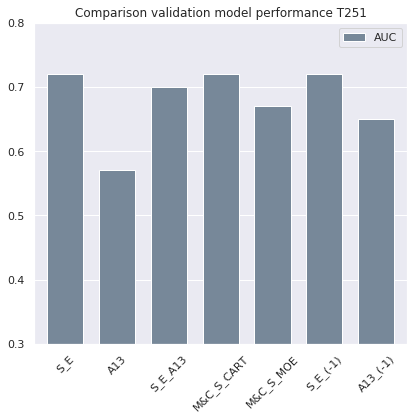

In [0]:
plot_results_bar(results_df=results_table, title="Comparison validation model performance T251", saveloc=fig_loc+"comparison_validation_model_performance_T251_NEW.png", fig_size=(6,6), fig_lim=(0.3,.8))

In [0]:
results_table

,AUC
S_E,0.72
A13,0.57
S_E_A13,0.70
M&C_S_CART,0.72
M&C_S_MOE,0.67
S_E_(-1),0.72
A13_(-1),0.65


In [0]:
results_table.to_csv(fig_loc+"comparison_retrospective_T251_results_table_NEW.csv")

## Visualize model paper (S_E) perfomance on a per protein basis

In [0]:
# Prepare data for XGBoost
dtest = xgb.DMatrix(X_paper)

In [0]:
y_pred = model_paper.predict(dtest)

In [0]:
print("Mean absolute error: ",mean_absolute_error(y_label, y_pred))
print("Root mean squared error: ",np.sqrt(mean_squared_error(y_label, y_pred)))

Mean absolute error:  4.811606817587438
Root mean squared error:  6.315121490566644


In [0]:
mutation_idx = np.array(list(map(lambda x: x.split("@")[0],X_seq_all_01.index.copy())))

In [0]:
perf_per_prot = performance_per_protein_id(mutation_idx, y_label, y_pred)

In [0]:
perf_per_prot.head()

,mae,rmse,count
proteins,,,
1FTG,4.678693,6.236957,33
1PIN,4.423543,5.246268,30
1ARR,5.545470,6.990376,25
1STN,3.946835,5.299478,17
1ROP,3.488040,4.114909,15


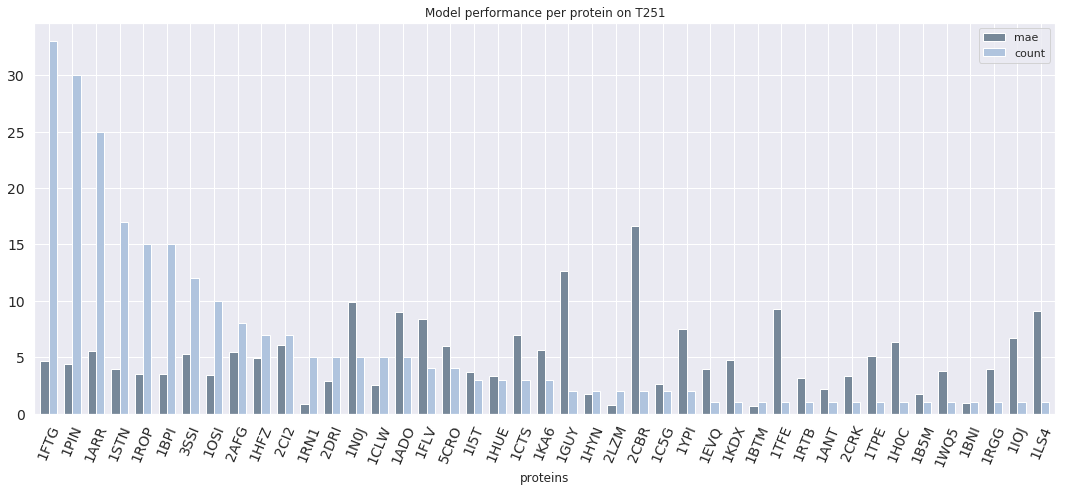

In [0]:
plot_per_protein_perf(perf_per_prot,"count","mae","Model performance per protein on T251",fig_loc+"model_paper_per_protein_performance.png")